# Final Project

For my final project, I'm going to be exploring the French trains dataset in the ```small_trains.csv``` file from [TidyTuesday](https://github.com/rfordatascience/tidytuesday/tree/master/data/2019/2019-02-26).

Let's start by loading in our packages and data.

In [1]:
library("tidyverse")
library("tidygraph")
library("ggraph")
library("ggrepel")

Warning message:
“replacing previous import ‘vctrs::data_frame’ by ‘tibble::data_frame’ when loading ‘dplyr’”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.1
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘tidygraph’


The following object is masked from ‘package:stats’:

    filter




In [2]:
french_trains = read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2019/2019-02-26/small_trains.csv",
                         col_types = cols(
                            year = col_double(),
                            month = col_double(),
                            service = col_character(),
                            departure_station = col_character(),
                            arrival_station = col_character(),
                            journey_time_avg = col_double(),
                            total_num_trips = col_double(),
                            avg_delay_all_departing = col_double(),
                            avg_delay_all_arriving = col_double(),
                            num_late_at_departure = col_double(),
                            num_arriving_late = col_double(),
                            delay_cause = col_character(),
                            delayed_number = col_double()))

print(french_trains)

# A tibble: 32,772 x 13
    year month service departure_stati… arrival_station journey_time_avg
   <dbl> <dbl> <chr>   <chr>            <chr>                      <dbl>
 1  2017     9 Nation… PARIS EST        METZ                        85.1
 2  2017     9 Nation… REIMS            PARIS EST                   47.1
 3  2017     9 Nation… PARIS EST        STRASBOURG                 116. 
 4  2017     9 Nation… PARIS LYON       AVIGNON TGV                161. 
 5  2017     9 Nation… PARIS LYON       BELLEGARDE (AI…            164. 
 6  2017     9 Nation… PARIS LYON       BESANCON FRANC…            129. 
 7  2017     9 Nation… CHAMBERY CHALLE… PARIS LYON                 184. 
 8  2017     9 Nation… PARIS LYON       GRENOBLE                   186. 
 9  2017     9 Nation… LYON PART DIEU   PARIS LYON                 121. 
10  2017     9 Nation… PARIS LYON       MACON LOCHE                 97.4
# … with 32,762 more rows, and 7 more variables: total_num_trips <dbl>,
#   avg_delay_all_departing 

To begin, I'd like to see where these trains are going, so I'll make a graph with nodes and edges. Let's start with the easier step, creating the nodes. To create the nodes, I will:
1. Combine the ```departure_station``` and ```arrival_station``` variables into a vector without duplicates
2. Make a ```tibble``` including my new vector as a variable called ```station``` and an ```id``` variable equal to the row number

In [3]:
all_stations <- unique(c(french_trains$departure_station, french_trains$arrival_station))
all_train_nodes <- tibble(station = all_stations) %>%
    mutate(id = row_number())

print(all_train_nodes)

# A tibble: 59 x 2
   station                      id
   <chr>                     <int>
 1 PARIS EST                     1
 2 REIMS                         2
 3 PARIS LYON                    3
 4 CHAMBERY CHALLES LES EAUX     4
 5 LYON PART DIEU                5
 6 MONTPELLIER                   6
 7 MULHOUSE VILLE                7
 8 PARIS MONTPARNASSE            8
 9 BORDEAUX ST JEAN              9
10 LA ROCHELLE VILLE            10
# … with 49 more rows


Creating the edges requires a few more steps. I first need to create a ```tibble``` with all the train routes, or all combinations of ```departure_station``` and ```arrival_station```, across the dataset's timespan from 2015 to 2018. Since my dataset contains ```num_of_trips``` to capture how many trips are taken on each route, I'd also like to include this information in my final graph.

In [4]:
all_train_routes = french_trains %>%
    group_by(departure_station, arrival_station) %>%
    summarize(total_trips = sum(total_num_trips)) %>%
    ungroup()

print(all_train_routes)

`summarise()` regrouping output by 'departure_station' (override with `.groups` argument)



# A tibble: 130 x 3
   departure_station          arrival_station    total_trips
   <chr>                      <chr>                    <dbl>
 1 AIX EN PROVENCE TGV        PARIS LYON              116346
 2 ANGERS SAINT LAUD          PARIS MONTPARNASSE      121890
 3 ANGOULEME                  PARIS MONTPARNASSE       87540
 4 ANNECY                     PARIS LYON               51204
 5 ARRAS                      PARIS NORD               91350
 6 AVIGNON TGV                PARIS LYON              155658
 7 BARCELONA                  PARIS LYON                4734
 8 BELLEGARDE (AIN)           PARIS LYON               65094
 9 BESANCON FRANCHE COMTE TGV PARIS LYON               55968
10 BORDEAUX ST JEAN           PARIS MONTPARNASSE      202992
# … with 120 more rows


Now I need a ```from``` and ```to``` column that represent the ```departure_station``` and ```arrival_station``` respectively but instead hold the ```id``` number associated with the station from our nodes table rather than the station name itself. To do this, I'll join ```all_train_routes``` and ```all_train_nodes``` to create our final ```tibble``` of edges.

In [5]:
all_train_edges = all_train_routes %>%
    right_join(all_train_nodes %>% select(station, id), by = c("departure_station" = "station")) %>%
    right_join(all_train_nodes %>% select(station, id), by = c("arrival_station" = "station")) %>%
    rename(from = id.x) %>%
    rename(to = id.y)

print(all_train_edges)

# A tibble: 130 x 5
   departure_station          arrival_station    total_trips  from    to
   <chr>                      <chr>                    <dbl> <int> <int>
 1 AIX EN PROVENCE TGV        PARIS LYON              116346    53     3
 2 ANGERS SAINT LAUD          PARIS MONTPARNASSE      121890    14     8
 3 ANGOULEME                  PARIS MONTPARNASSE       87540    36     8
 4 ANNECY                     PARIS LYON               51204    47     3
 5 ARRAS                      PARIS NORD               91350    39    19
 6 AVIGNON TGV                PARIS LYON              155658    31     3
 7 BARCELONA                  PARIS LYON                4734    58     3
 8 BELLEGARDE (AIN)           PARIS LYON               65094    45     3
 9 BESANCON FRANCHE COMTE TGV PARIS LYON               55968    34     3
10 BORDEAUX ST JEAN           PARIS MONTPARNASSE      202992     9     8
# … with 120 more rows


Now we have all the components we need to create our graph and visualization.

In [6]:
all_trains_graph = tbl_graph(all_train_nodes, all_train_edges)
print(all_trains_graph)

# A tbl_graph: 59 nodes and 130 edges
#
# A directed simple graph with 1 component
#
# Node Data: 59 x 2 (active)
  station                      id
  <chr>                     <int>
1 PARIS EST                     1
2 REIMS                         2
3 PARIS LYON                    3
4 CHAMBERY CHALLES LES EAUX     4
5 LYON PART DIEU                5
6 MONTPELLIER                   6
# … with 53 more rows
#
# Edge Data: 130 x 5
   from    to departure_station   arrival_station    total_trips
  <int> <int> <chr>               <chr>                    <dbl>
1    53     3 AIX EN PROVENCE TGV PARIS LYON              116346
2    14     8 ANGERS SAINT LAUD   PARIS MONTPARNASSE      121890
3    36     8 ANGOULEME           PARIS MONTPARNASSE       87540
# … with 127 more rows


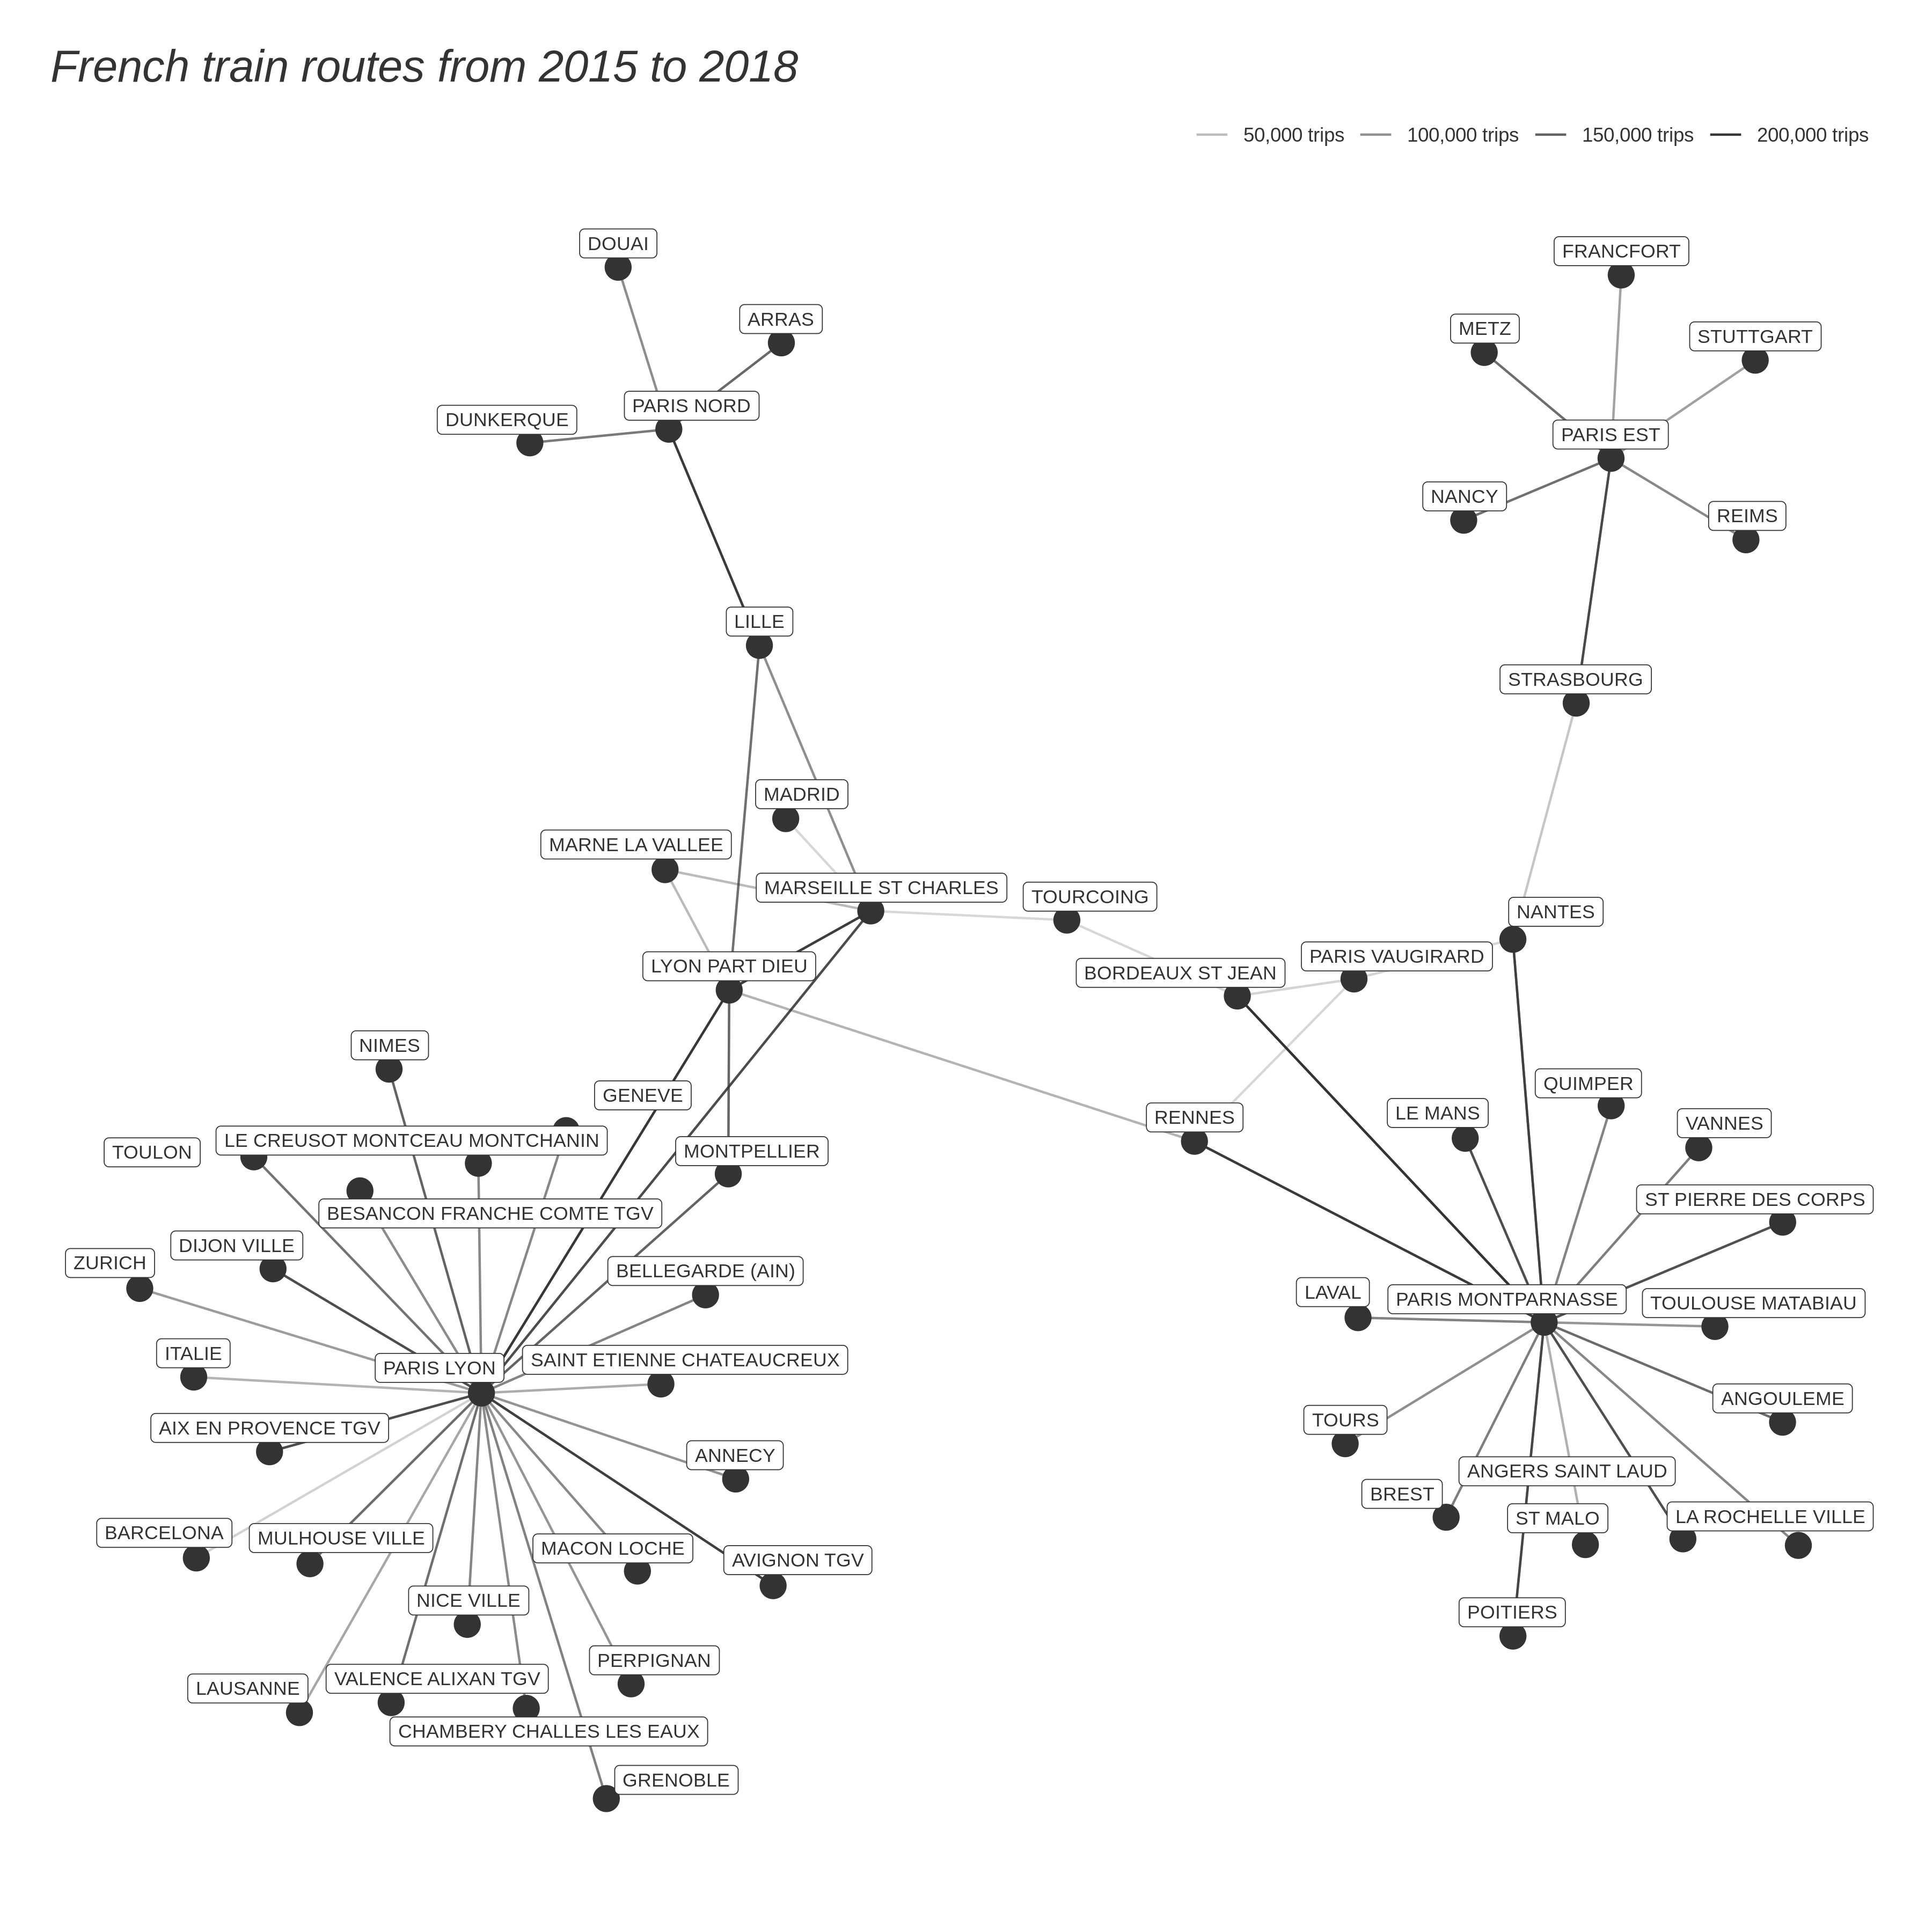

In [7]:
options(repr.plot.width = 12, repr.plot.height = 12, repr.plot.res = 300)

ggraph(all_trains_graph, layout = "dh") +
    geom_edge_link(aes(alpha = total_trips), color = "#333333") +
    geom_node_point(color = "#333333",
                    fill = "#333333",
                    size = 5,
                    shape = 21) + 
    scale_edge_alpha("",
                    breaks = c(50000, 100000, 150000, 200000),
                    labels = c("50,000 trips", "100,000 trips", "150,000 trips", "200,000 trips")) +
    geom_label_repel(aes(x = x, y = y, label = station),nudge_y = 0.1,
                     label.size = .2,
                     size = 3,
                     segment.color = "transparent",
                     color = "#333333") +
    labs(
        title = "French train routes from 2015 to 2018"
    ) +
    theme(
        plot.margin = unit(c(.8,.8,.8,.8),"cm"),
        plot.title.position = "plot",
        plot.title = element_text(size = 20, face = "italic", color = "#333333"),
        panel.background = element_rect(fill = "white"),
        legend.position = "top",
        legend.justification = "right",
        legend.text = element_text(color = "#333333"),
        legend.key = element_rect(fill = "white"))

Unsurprisingly, it looks like the four train stations in Paris, especially ```PARIS LYON``` and ```PARIS MONTPARNASSE```, do a lot of the heavy lifting. Other stations with a decent amount of traffic seem to serve as connectors to Paris for routes to smaller cities.

Next, I'd like to explore delays in train departures and arrivals, which are incorporated in the ```num_late_at_departure``` and ```num_arriving_late``` variables respectively. First, I'd like to create a new table with the percent of trains departing late and the percent of trains arriving late using the ```total_num_trips``` variable. I'd also like to preserve ```year``` in this dataset to see whether delays look different between years. I'll also make a new variable called ```dep_arr``` to store the train routes in a ```departure_station```-```arrival_station``` format.

In [8]:
late_trains = french_trains %>%
    group_by(departure_station, arrival_station, year) %>%
    summarize(sum_late_at_departure = sum(num_late_at_departure),
              sum_arriving_late = sum(num_arriving_late),
              total_trips = sum(total_num_trips)) %>%
    ungroup() %>%
    mutate(percent_late_at_departure = sum_late_at_departure/total_trips*100,
           percent_arriving_late = sum_arriving_late/total_trips*100)

dep_arr = unite(late_trains %>% select(departure_station, arrival_station), col = dep_arr, sep = "-")$dep_arr
late_trains = late_trains %>% mutate(dep_arr = dep_arr)

late_trains

`summarise()` regrouping output by 'departure_station', 'arrival_station' (override with `.groups` argument)



departure_station          arrival_station      year sum_late_at_departure
1   AIX EN PROVENCE TGV        PARIS LYON           2015  4470                
2   AIX EN PROVENCE TGV        PARIS LYON           2016  3720                
3   AIX EN PROVENCE TGV        PARIS LYON           2017  4008                
4   AIX EN PROVENCE TGV        PARIS LYON           2018  9750                
5   ANGERS SAINT LAUD          PARIS MONTPARNASSE   2015  2754                
6   ANGERS SAINT LAUD          PARIS MONTPARNASSE   2016  2994                
7   ANGERS SAINT LAUD          PARIS MONTPARNASSE   2017  4992                
8   ANGERS SAINT LAUD          PARIS MONTPARNASSE   2018 10770                
9   ANGOULEME                  PARIS MONTPARNASSE   2015  3444                
10  ANGOULEME                  PARIS MONTPARNASSE   2016  6426                
11  ANGOULEME                  PARIS MONTPARNASSE   2017  5262                
12  ANGOULEME                  PARIS MONTPARNASSE   2018  7404                
13  ANNECY                     PARIS LYON           2015   318                
14  ANNECY                     PARIS LYON           2016   240                
15  ANNECY                     PARIS LYON           2017   426                
16  ANNECY                     PARIS LYON           2018  1026                
17  ARRAS                      PARIS NORD           2015  2220                
18  ARRAS                      PARIS NORD           2016  1572                
19  ARRAS                      PARIS NORD           2017  3078                
20  ARRAS                      PARIS NORD           2018  7098                
21  AVIGNON TGV                PARIS LYON           2015  9840                
22  AVIGNON TGV                PARIS LYON           2016  8112                
23  AVIGNON TGV                PARIS LYON           2017  8688                
24  AVIGNON TGV                PARIS LYON           2018 14184                
25  BARCELONA                  PARIS LYON           2018  1692                
26  BELLEGARDE (AIN)           PARIS LYON           2015  2364                
27  BELLEGARDE (AIN)           PARIS LYON           2016  2652                
28  BELLEGARDE (AIN)           PARIS LYON           2017  2754                
29  BELLEGARDE (AIN)           PARIS LYON           2018  5460                
30  BESANCON FRANCHE COMTE TGV PARIS LYON           2015   456                
⋮   ⋮                          ⋮                    ⋮    ⋮                    
437 STUTTGART                  PARIS EST            2015  3666                
438 STUTTGART                  PARIS EST            2016  2616                
439 STUTTGART                  PARIS EST            2017  2460                
440 STUTTGART                  PARIS EST            2018  7494                
441 TOULON                     PARIS LYON           2015  5592                
442 TOULON                     PARIS LYON           2016  5130                
443 TOULON                     PARIS LYON           2017  5832                
444 TOULON                     PARIS LYON           2018  7302                
445 TOULOUSE MATABIAU          PARIS MONTPARNASSE   2015   444                
446 TOULOUSE MATABIAU          PARIS MONTPARNASSE   2016   516                
447 TOULOUSE MATABIAU          PARIS MONTPARNASSE   2017   750                
448 TOULOUSE MATABIAU          PARIS MONTPARNASSE   2018  1404                
449 TOURCOING                  BORDEAUX ST JEAN     2018   246                
450 TOURCOING                  MARSEILLE ST CHARLES 2018   180                
451 TOURS                      PARIS MONTPARNASSE   2015   216                
452 TOURS                      PARIS MONTPARNASSE   2016   372                
453 TOURS                      PARIS MONTPARNASSE   2017   258                
454 TOURS                      PARIS MONTPARNASSE   2018  1086                
455 VALENCE ALIXAN TGV         PARIS LYON           20

Now I'm going to filter ```late_trains``` to only include routes that have valid ```percent_late_at_departure``` and ```percent_arriving_late``` values for years from 2015 to 2018 and create two lollipop charts to show the delays at departure and arrival between 2015 and 2018.

In [9]:
late_trains_filter = late_trains %>% group_by(dep_arr) %>%
    filter(n() == 4,
           percent_late_at_departure != "NA",
           percent_arriving_late != "NA")

print(late_trains_filter)

# A tibble: 444 x 9
# Groups:   dep_arr [112]
   departure_stati… arrival_station  year sum_late_at_dep… sum_arriving_la…
   <chr>            <chr>           <dbl>            <dbl>            <dbl>
 1 AIX EN PROVENCE… PARIS LYON       2015             4470             2850
 2 AIX EN PROVENCE… PARIS LYON       2016             3720             2196
 3 AIX EN PROVENCE… PARIS LYON       2017             4008             3954
 4 AIX EN PROVENCE… PARIS LYON       2018             9750             3120
 5 ANGERS SAINT LA… PARIS MONTPARN…  2015             2754             2802
 6 ANGERS SAINT LA… PARIS MONTPARN…  2016             2994             2964
 7 ANGERS SAINT LA… PARIS MONTPARN…  2017             4992             5508
 8 ANGERS SAINT LA… PARIS MONTPARN…  2018            10770             5124
 9 ANGOULEME        PARIS MONTPARN…  2015             3444             2550
10 ANGOULEME        PARIS MONTPARN…  2016             6426             3918
# … with 434 more rows, and 4 more variabl

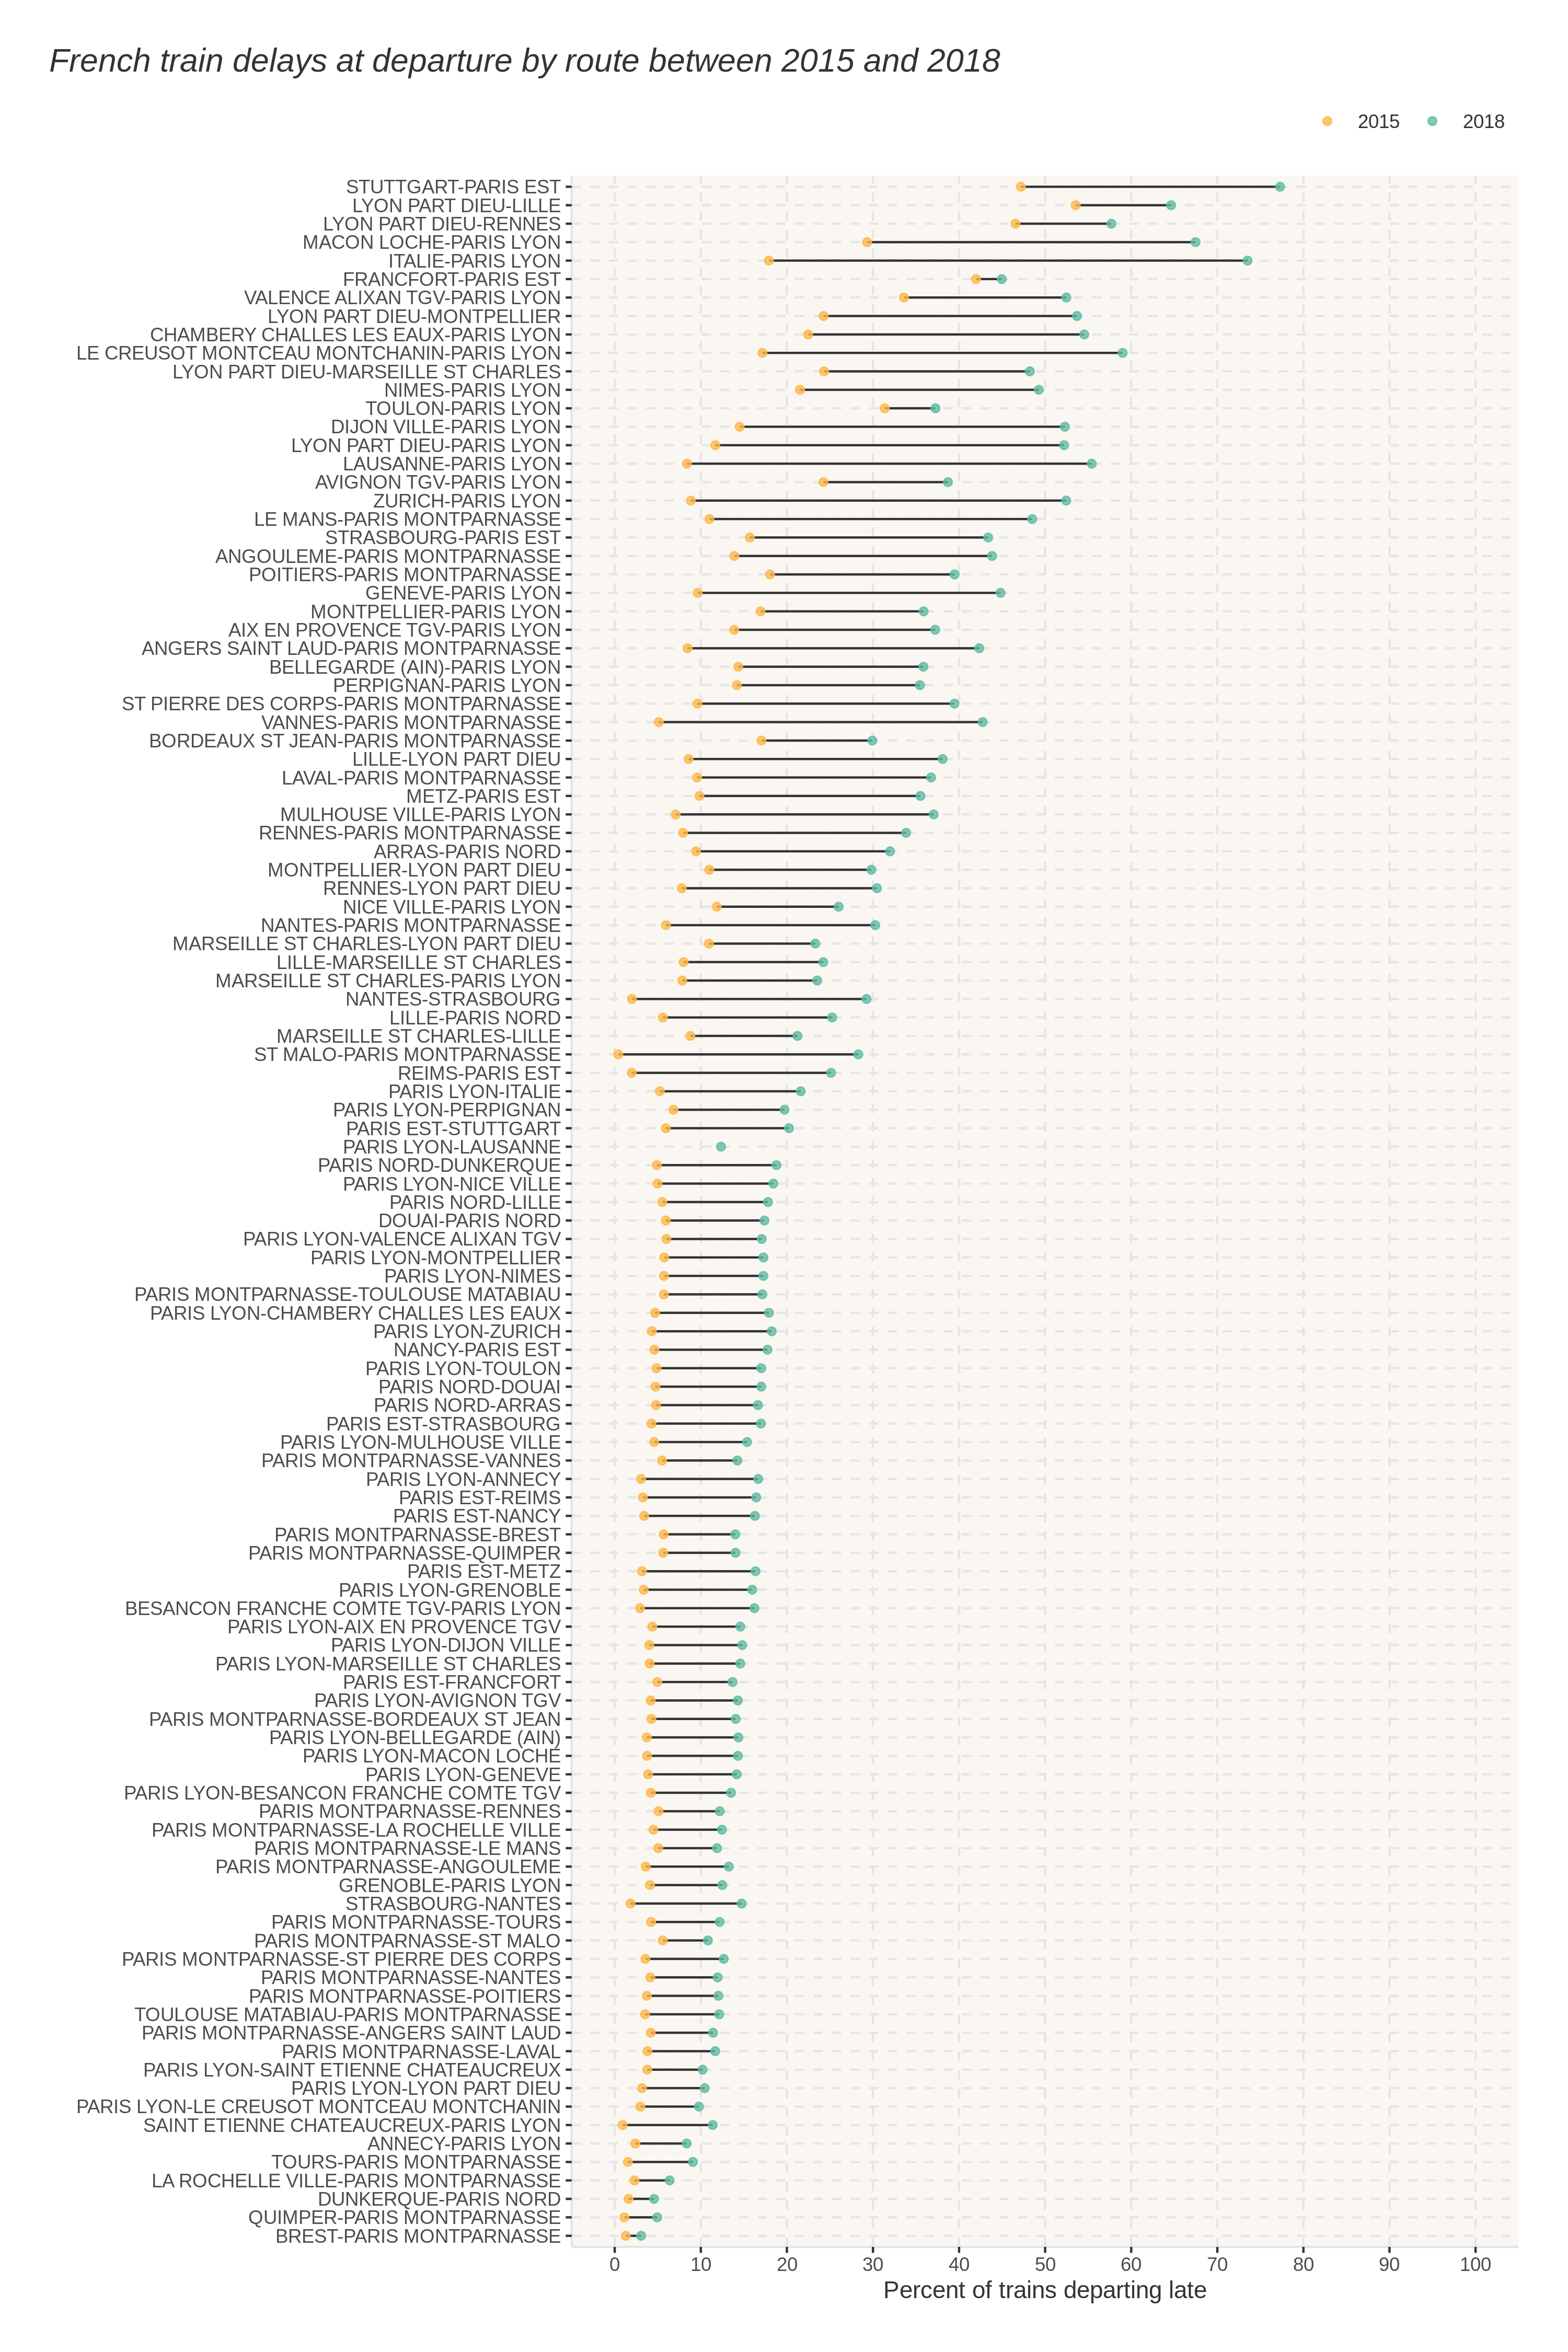

In [10]:
options(repr.plot.width = 10, repr.plot.height = 15, repr.plot.res = 300)

ggplot(late_trains_filter %>% filter(year == 2015 | year == 2018),
       aes(y = fct_reorder(dep_arr, percent_late_at_departure, .fun = mean), x = percent_late_at_departure, color = factor(year))) +
    geom_line(aes(group = dep_arr), color = "#333333") +
    geom_point(alpha = .8) +
    labs(x = "Percent of trains departing late",
         y = "",
         color = "",
         title = "French train delays at departure by route between 2015 and 2018") +
    scale_x_continuous(breaks = seq(0, 100, by = 10),
                       limits = c(0, 100)) +
    scale_color_manual(values = c("#ffb84d", "#62bba5")) +
    theme(
        plot.margin = unit(c(.8,.8,.8,.8),"cm"),
        plot.title = element_text(size = 15, face = "italic", color = "#333333"),
        plot.title.position = "plot",
        panel.background = element_rect(fill = "#faf7f2"),
        panel.grid.major = element_line(linetype = "dashed", color = "gray90"),
        panel.grid.minor = element_blank(),
        axis.title = element_text(color = "#333333"),
        axis.line = element_line(linetype = "solid", color = "gray90"),
        legend.position = "top",
        legend.justification = "right",
        legend.text = element_text(color = "#333333"),
        legend.key = element_rect(fill = "white"))

Nearly all routes had a higher percent of trains departing late in 2018 compared to in 2015. It also looks like our ```PARIS LYON-LAUSANNE``` route has a missing percent value for 2015. Let's filter out this station and create the same visualization for the percent of trains arriving late. This time, I'm also going to sort the data by the minimum percent value.

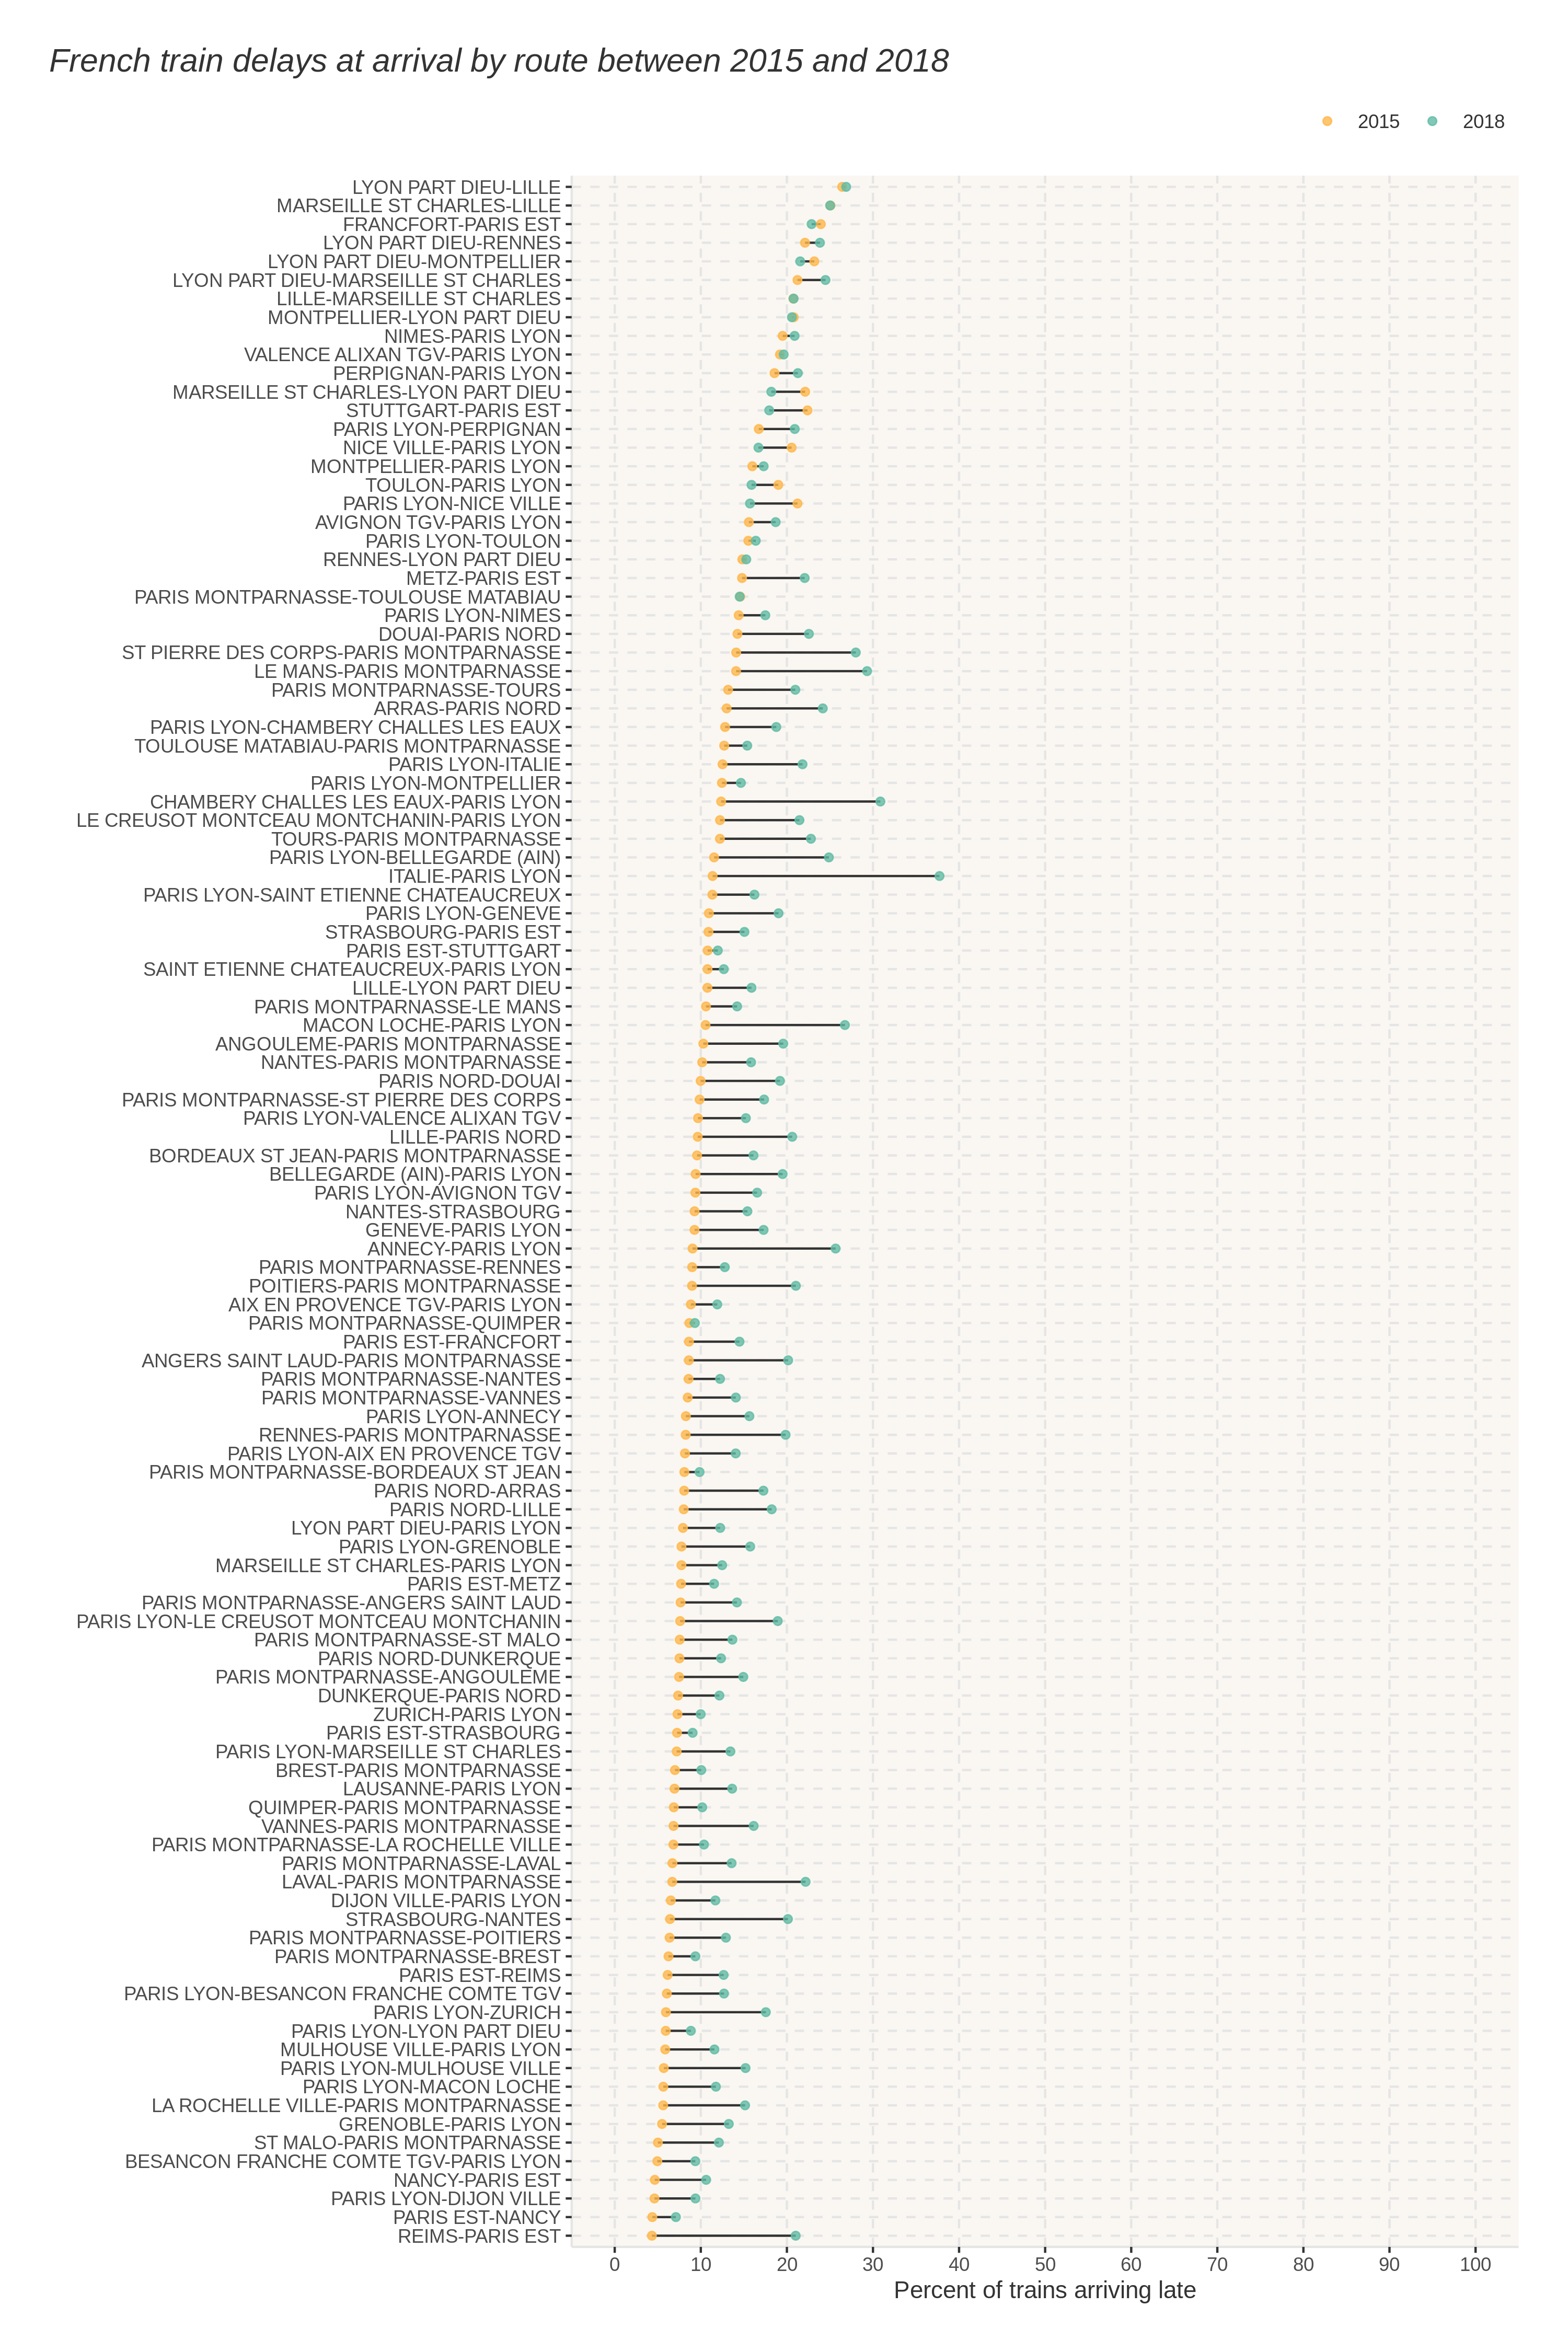

In [11]:
options(repr.plot.width = 10, repr.plot.height = 15, repr.plot.res = 300)

ggplot(late_trains_filter %>% filter(year == 2015 | year == 2018, dep_arr != "PARIS LYON-LAUSANNE"),
       aes(y = fct_reorder(dep_arr, percent_arriving_late, .fun = min), x = percent_arriving_late, color = factor(year))) +
    geom_line(aes(group = dep_arr), color = "#333333") +
    geom_point(alpha = .8) +
    labs(x = "Percent of trains arriving late",
         y = "",
         color = "",
         title = "French train delays at arrival by route between 2015 and 2018") +
    scale_x_continuous(breaks = seq(0, 100, by = 10),
                       limits = c(0, 100)) +
    scale_color_manual(values = c("#ffb84d", "#62bba5")) +
    theme(
        plot.margin = unit(c(.8,.8,.8,.8),"cm"),
        plot.title = element_text(size = 15, face = "italic", color = "#333333"),
        plot.title.position = "plot",
        panel.background = element_rect(fill = "#faf7f2"),
        panel.grid.major = element_line(linetype = "dashed", color = "gray90"),
        panel.grid.minor = element_blank(),
        axis.title = element_text(color = "#333333"),
        axis.line = element_line(linetype = "solid", color = "gray90"),
        legend.position = "top",
        legend.justification = "right",
        legend.text = element_text(color = "#333333"),
        legend.key = element_rect(fill = "white"))

The trend looks very similar for the percent of trains arriving late between 2015 and 2018. Overall, however, there appear to be more trains late at departure than at arrival, suggesting they may be good at making up the lost time. According to [Mathilda](https://tender-curie-5b83bc.netlify.app/2019/02/12/exploration-of-french-high-speed-trains-delays-part-2/), there was a 3-month strike in 2018 that contributed to many delays and cancellations. Let's make a couple of final visualizations to see in which months of 2018 these delays occurred. First, we'll make a second dataset similar to ```late_trains``` but adding the variable ```month``` and filtering the ```year``` to 2018.

In [12]:
late_trains2 = french_trains %>%
    group_by(departure_station, arrival_station, year, month) %>%
    summarize(sum_late_at_departure = sum(num_late_at_departure),
              sum_arriving_late = sum(num_arriving_late),
              total_trips = sum(total_num_trips)) %>%
    ungroup() %>%
    mutate(percent_late_at_departure = sum_late_at_departure/total_trips*100,
           percent_arriving_late = sum_arriving_late/total_trips*100)

dep_arr = unite(late_trains2 %>% select(departure_station, arrival_station), col = dep_arr, sep = "-")$dep_arr
late_trains2 = late_trains2 %>% mutate(dep_arr = dep_arr) %>% filter(year == 2018)

late_trains2

`summarise()` regrouping output by 'departure_station', 'arrival_station', 'year' (override with `.groups` argument)



departure_station   arrival_station    year month sum_late_at_departure
1    AIX EN PROVENCE TGV PARIS LYON         2018  1     702                 
2    AIX EN PROVENCE TGV PARIS LYON         2018  2     858                 
3    AIX EN PROVENCE TGV PARIS LYON         2018  3     888                 
4    AIX EN PROVENCE TGV PARIS LYON         2018  4     768                 
5    AIX EN PROVENCE TGV PARIS LYON         2018  5     282                 
6    AIX EN PROVENCE TGV PARIS LYON         2018  6     234                 
7    AIX EN PROVENCE TGV PARIS LYON         2018  7    1380                 
8    AIX EN PROVENCE TGV PARIS LYON         2018  8    1548                 
9    AIX EN PROVENCE TGV PARIS LYON         2018  9    1128                 
10   AIX EN PROVENCE TGV PARIS LYON         2018 10     978                 
11   AIX EN PROVENCE TGV PARIS LYON         2018 11     984                 
12   ANGERS SAINT LAUD   PARIS MONTPARNASSE 2018  1    1224                 
13   ANGERS SAINT LAUD   PARIS MONTPARNASSE 2018  2    1074                 
14   ANGERS SAINT LAUD   PARIS MONTPARNASSE 2018  3     996                 
15   ANGERS SAINT LAUD   PARIS MONTPARNASSE 2018  4     834                 
16   ANGERS SAINT LAUD   PARIS MONTPARNASSE 2018  5     330                 
17   ANGERS SAINT LAUD   PARIS MONTPARNASSE 2018  6     330                 
18   ANGERS SAINT LAUD   PARIS MONTPARNASSE 2018  7    1278                 
19   ANGERS SAINT LAUD   PARIS MONTPARNASSE 2018  8    1278                 
20   ANGERS SAINT LAUD   PARIS MONTPARNASSE 2018  9    1146                 
21   ANGERS SAINT LAUD   PARIS MONTPARNASSE 2018 10    1176                 
22   ANGERS SAINT LAUD   PARIS MONTPARNASSE 2018 11    1104                 
23   ANGOULEME           PARIS MONTPARNASSE 2018  1     810                 
24   ANGOULEME           PARIS MONTPARNASSE 2018  2     870                 
25   ANGOULEME           PARIS MONTPARNASSE 2018  3     774                 
26   ANGOULEME           PARIS MONTPARNASSE 2018  4     540                 
27   ANGOULEME           PARIS MONTPARNASSE 2018  5     198                 
28   ANGOULEME           PARIS MONTPARNASSE 2018  6     180                 
29   ANGOULEME           PARIS MONTPARNASSE 2018  7     714                 
30   ANGOULEME           PARIS MONTPARNASSE 2018  8     738                 
⋮    ⋮                   ⋮                  ⋮    ⋮     ⋮                    
1401 VALENCE ALIXAN TGV  PARIS LYON         2018  4     726                 
1402 VALENCE ALIXAN TGV  PARIS LYON         2018  5     432                 
1403 VALENCE ALIXAN TGV  PARIS LYON         2018  6     600                 
1404 VALENCE ALIXAN TGV  PARIS LYON         2018  7    1572                 
1405 VALENCE ALIXAN TGV  PARIS LYON         2018  8    1362                 
1406 VALENCE ALIXAN TGV  PARIS LYON         2018  9    1056                 
1407 VALENCE ALIXAN TGV  PARIS LYON         2018 10    1074                 
1408 VALENCE ALIXAN TGV  PARIS LYON         2018 11    1152                 
1409 VANNES              PARIS MONTPARNASSE 2018  1    1008                 
1410 VANNES              PARIS MONTPARNASSE 2018  2     870                 
1411 VANNES              PARIS MONTPARNASSE 2018  3     846                 
1412 VANNES              PARIS MONTPARNASSE 2018  4     618                 
1413 VANNES              PARIS MONTPARNASSE 2018  5      72                 
1414 VANNES              PARIS MONTPARNASSE 2018  6      90                 
1415 VANNES              PARIS MONTPARNASSE 2018  7     762                 
1416 VANNES              PARIS MONTPARNASSE 2018  8     948                 
1417 VANNES              PARIS MONTPARNASSE 2018  9     660                 
1418 VANNES              PARIS MONTPARNASSE 2018 10     720                 
1419 VANNES              PARIS MONTPARNASSE 2018 11     888                 
1420 ZURICH              PARIS LYON         2018  1     390                 
1

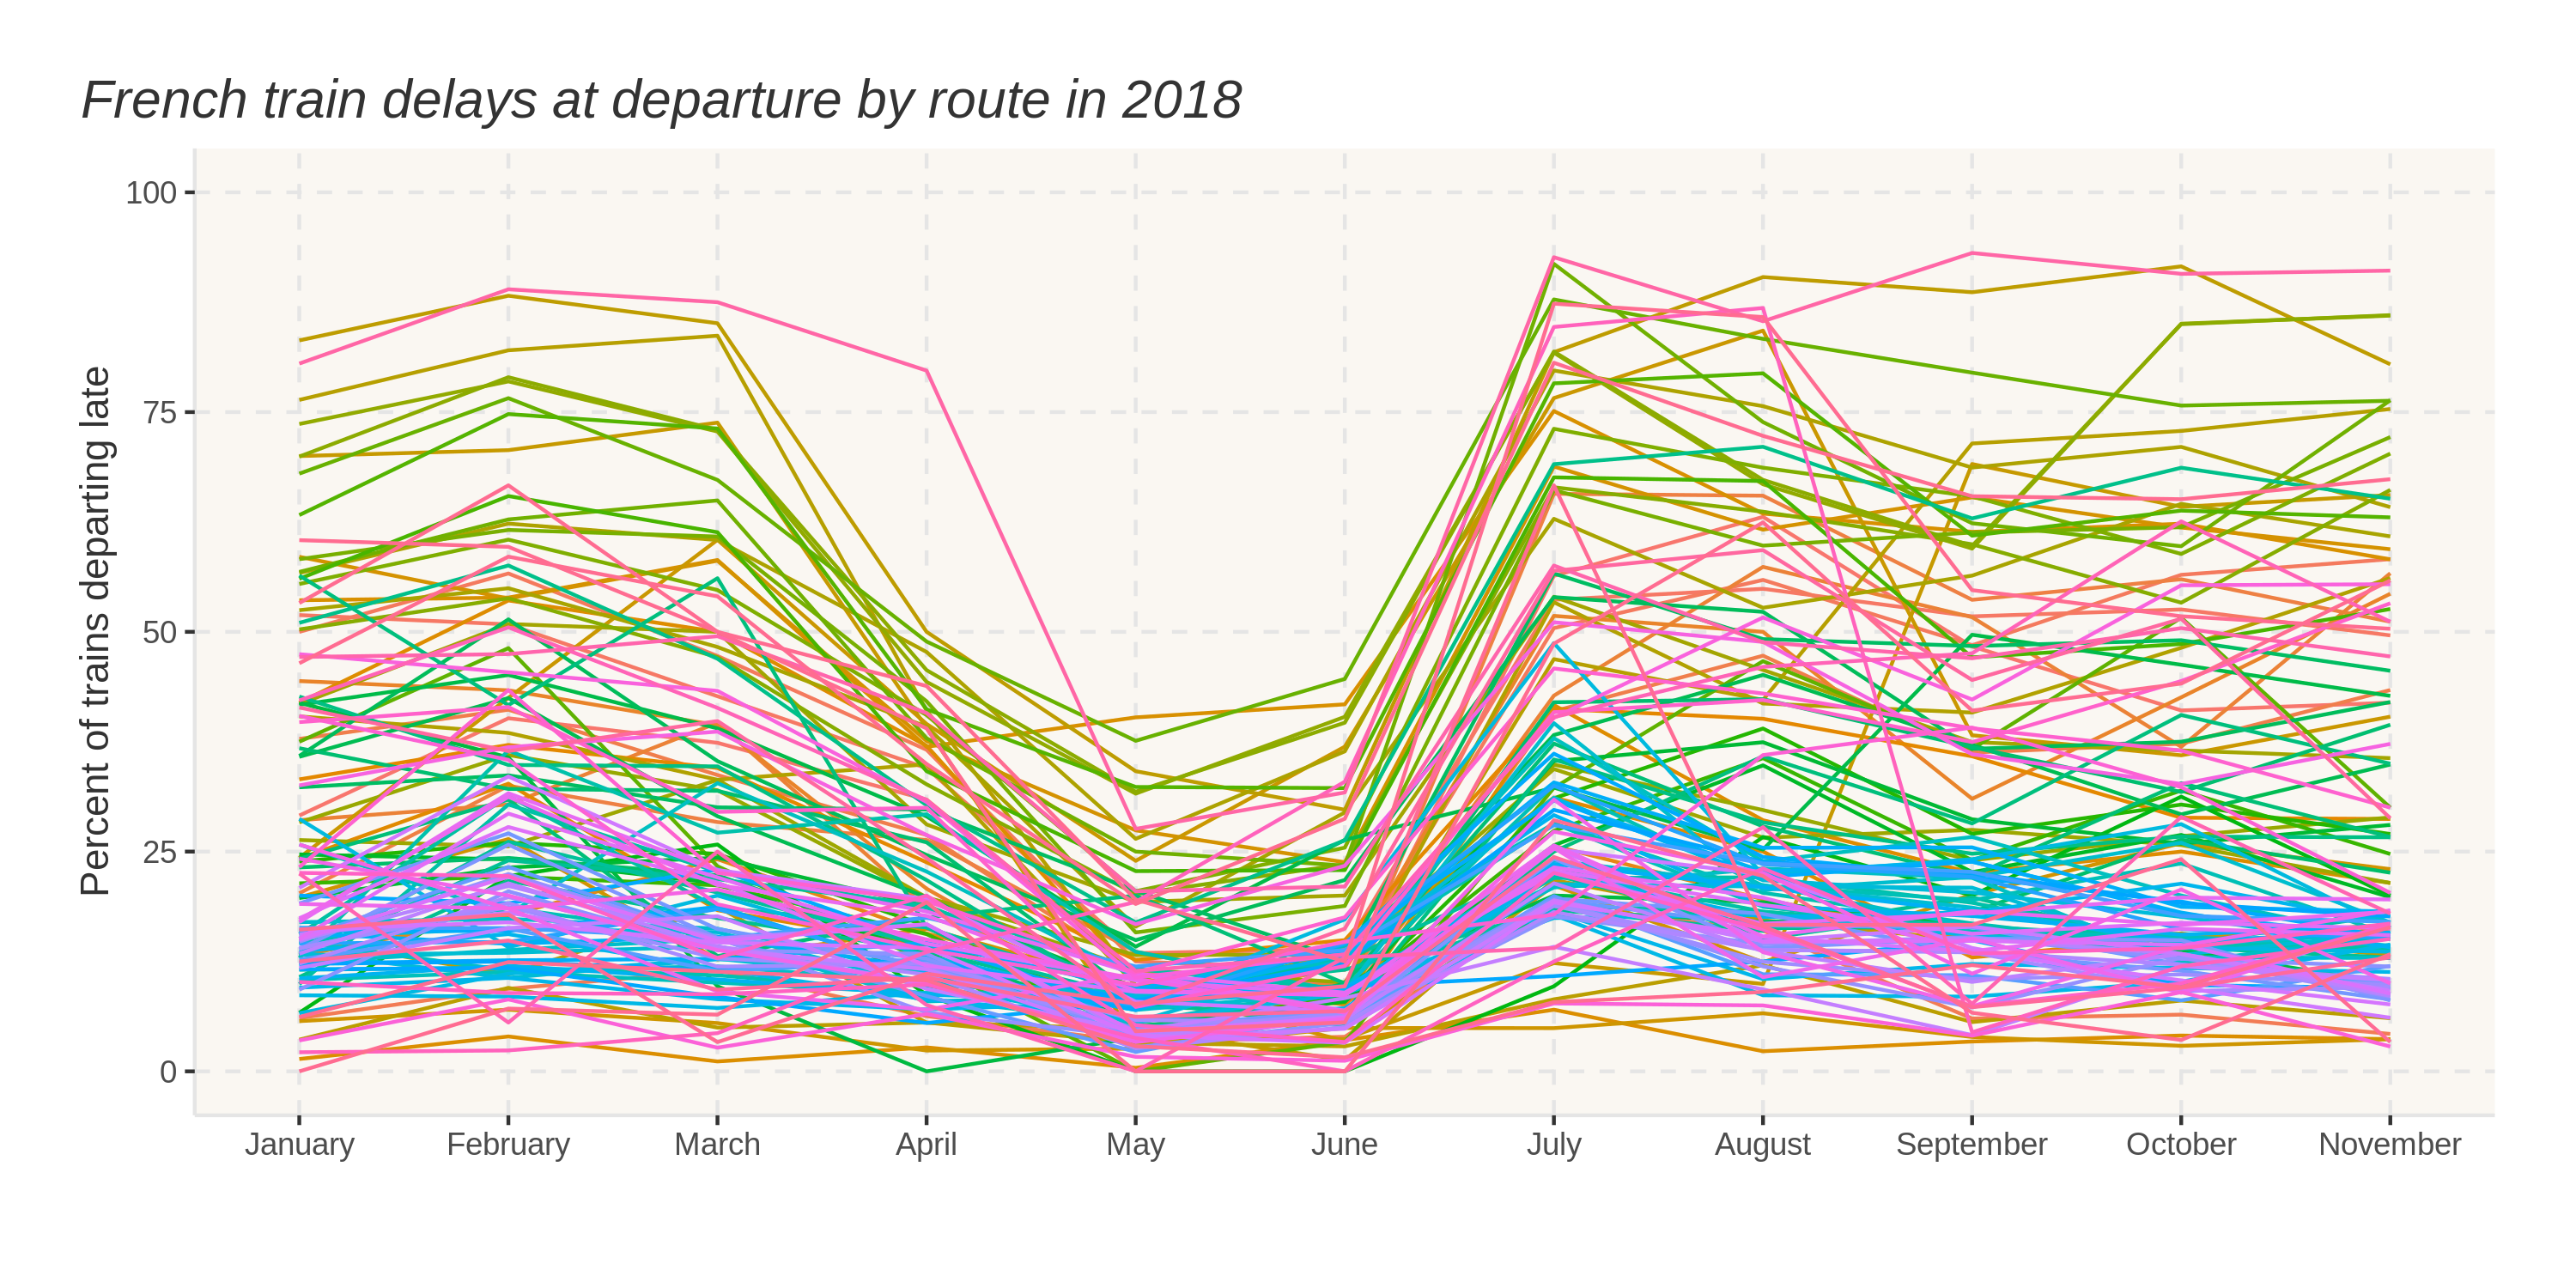

In [13]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 300)

ggplot(late_trains2, aes(x = month, y = percent_late_at_departure, color = dep_arr)) +
    geom_line() +
    scale_y_continuous(breaks = seq(0, 100, by = 25), limits = c(0, 100)) +
    scale_x_continuous(breaks = c(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12),  
                       labels = c("January",
                                  "February",
                                  "March",
                                  "April",
                                  "May",
                                  "June",
                                  "July",
                                  "August",
                                  "September",
                                  "October",
                                  "November",
                                  "December")) +
    labs(x = "",
         y = "Percent of trains departing late",
         color = "",
         title = "French train delays at departure by route in 2018") +
    theme(
        plot.margin = unit(c(.8,.8,.8,.8),"cm"),
        plot.title = element_text(size = 15, face = "italic", color = "#333333"),
        plot.title.position = "plot",
        panel.background = element_rect(fill = "#faf7f2"),
        panel.grid.major = element_line(linetype = "dashed", color = "gray90"),
        panel.grid.minor = element_blank(),
        axis.title = element_text(color = "#333333"),
        axis.line = element_line(linetype = "solid", color = "gray90"),
        legend.position = "none")

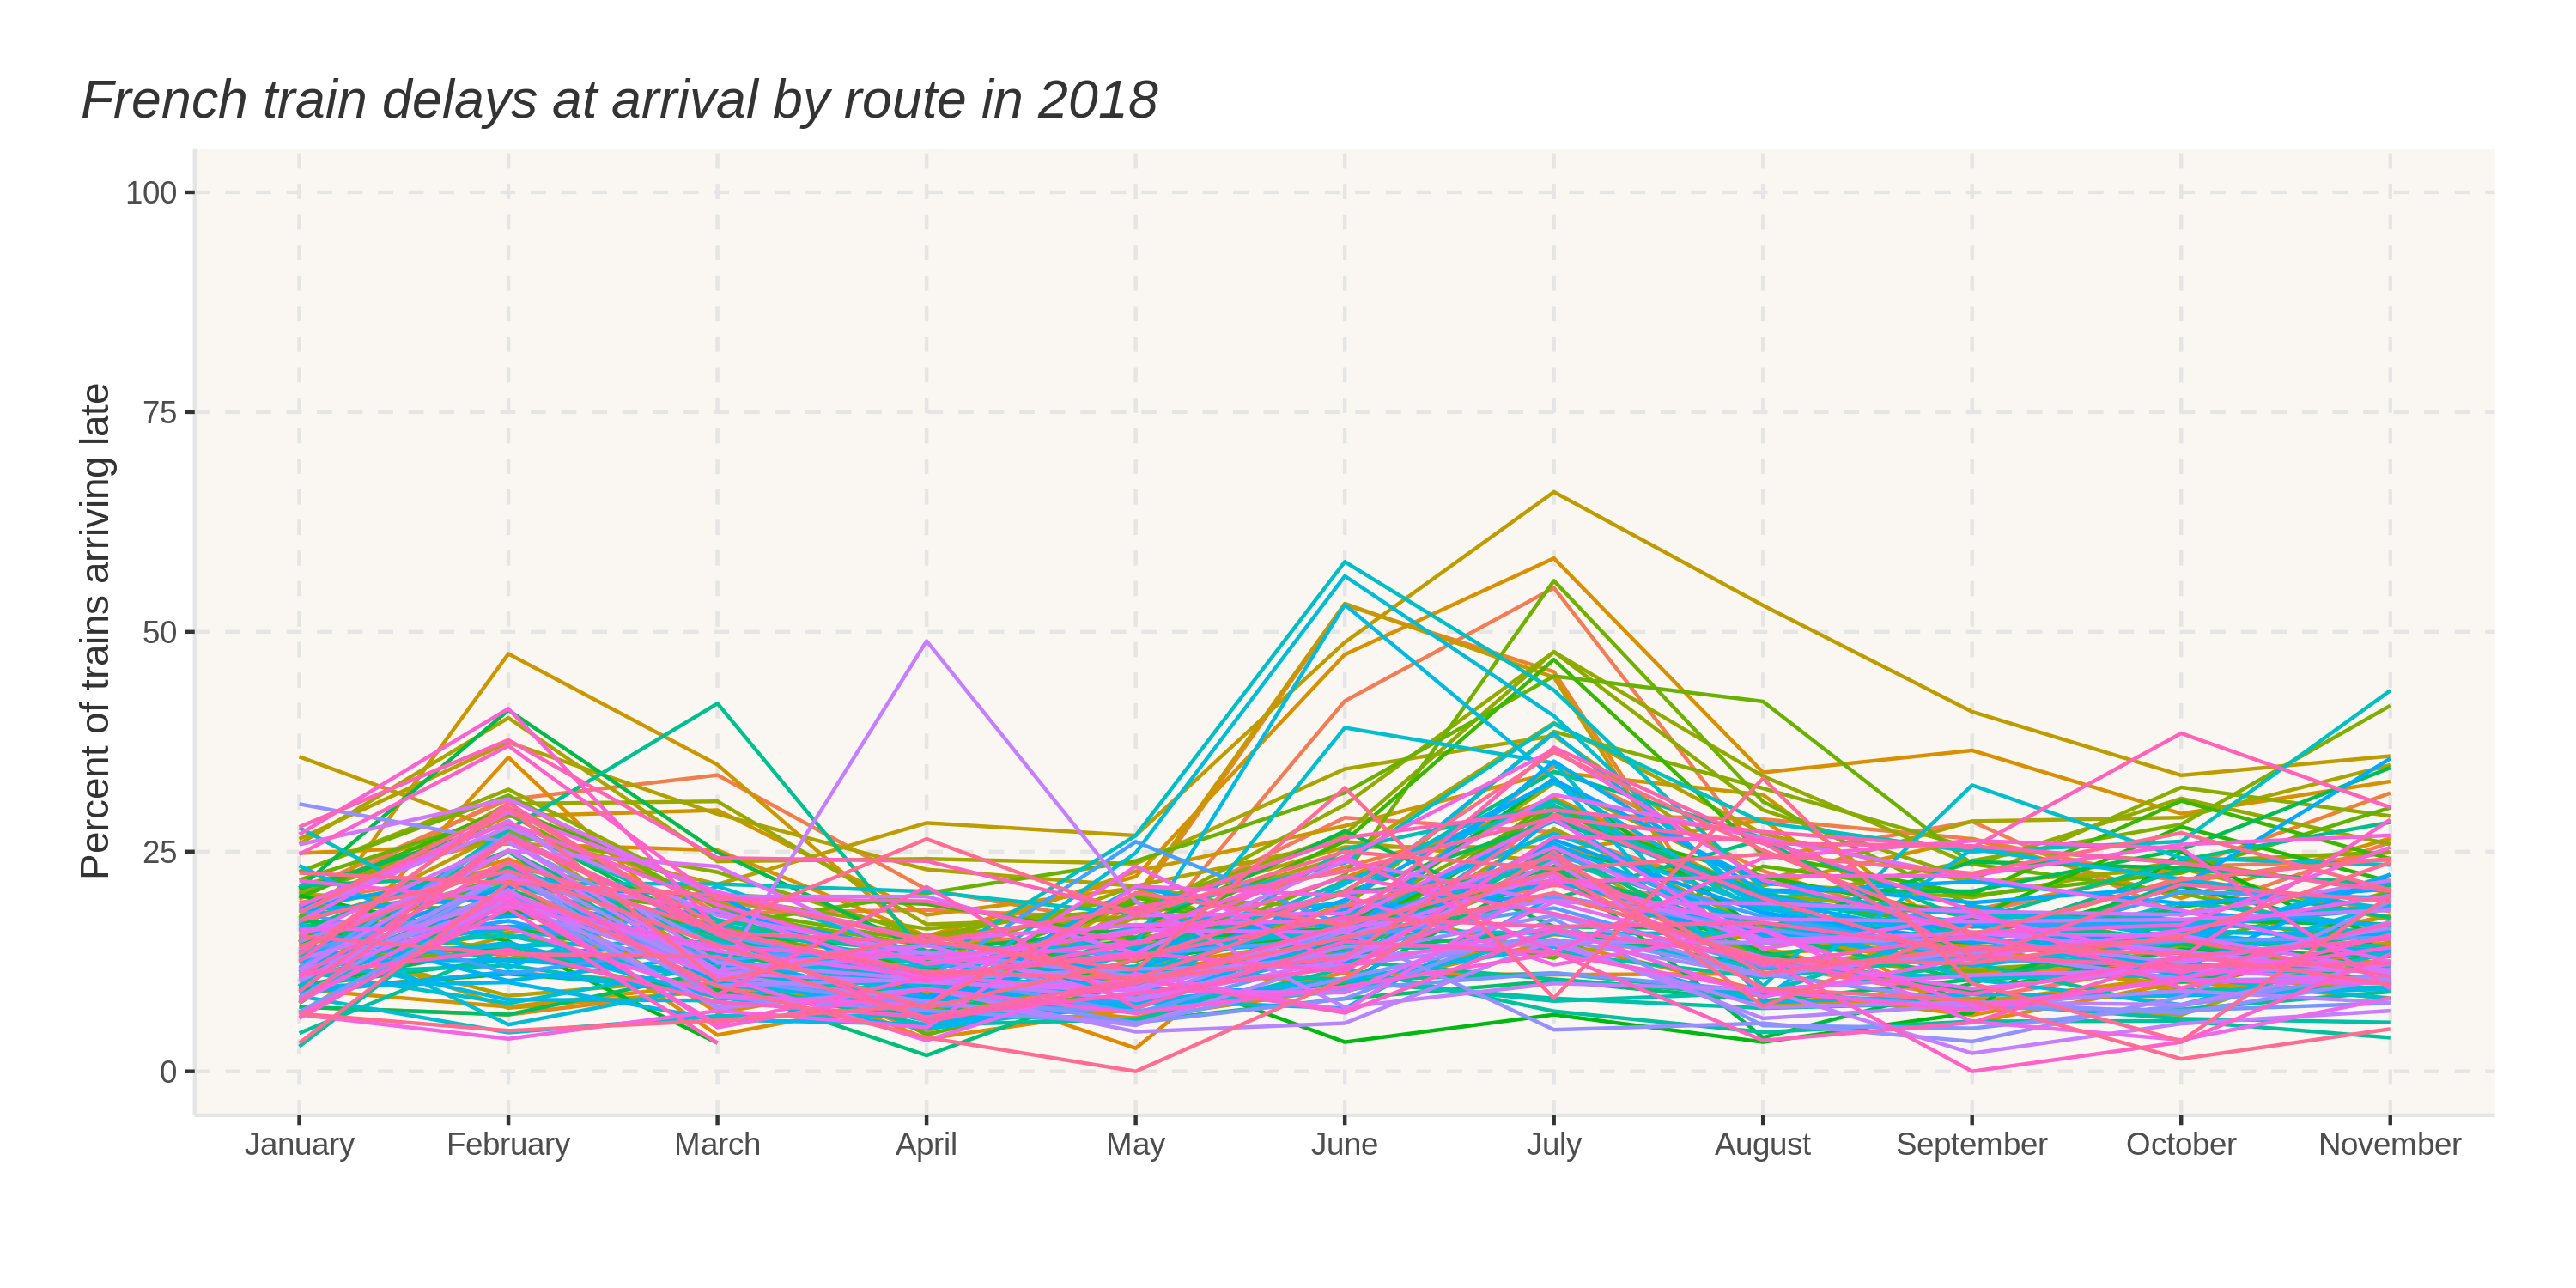

In [14]:
ggplot(late_trains2, aes(x = month, y = percent_arriving_late, color = dep_arr)) +
    geom_line() +
    scale_y_continuous(breaks = seq(0, 100, by = 25), limits = c(0, 100)) +
    scale_x_continuous(breaks = c(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12),  
                       labels = c("January",
                                  "February",
                                  "March",
                                  "April",
                                  "May",
                                  "June",
                                  "July",
                                  "August",
                                  "September",
                                  "October",
                                  "November",
                                  "December")) +
    labs(x = "",
         y = "Percent of trains arriving late",
         color = "",
         title = "French train delays at arrival by route in 2018") +
    theme(
        plot.margin = unit(c(.8,.8,.8,.8),"cm"),
        plot.title = element_text(size = 15, face = "italic", color = "#333333"),
        plot.title.position = "plot",
        panel.background = element_rect(fill = "#faf7f2"),
        panel.grid.major = element_line(linetype = "dashed", color = "gray90"),
        panel.grid.minor = element_blank(),
        axis.title = element_text(color = "#333333"),
        axis.line = element_line(linetype = "solid", color = "gray90"),
        legend.position = "none")

These figures once again illustrate that there are a greater percent of trains departing late than arriving late. The high percent of trains departing late dips from April through June in 2018, but the percent of trains arriving late stays relatively low and stable, with the possible exceptions of June and July. Although I am missing a lot of context to understand the 2018 strikes, it seems difficult to infer which 3 months they took place in from these visualizations.